# GBM Function Development

py37_benzene.yml environment

Development notebook that will be converted into a .py script for calling in real notebooks.

In [1]:
#import datetime # imports datetime for picking beginning and end dates for the analysis
import pandas as pd# imports pandas for dataframe manipulation
import numpy as np# imports numpy
import matplotlib as mpl# for data visualization
mpl.rcParams['figure.figsize'] = (25,8)# sets the plot size to 12x8
from matplotlib import pyplot as plt# for shorter lines with plotting
plt.rcParams['figure.figsize'] = (25,8)
from statsmodels.tsa.stattools import adfuller  # Statistical test for stationary data
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import os, sys
#from fitter import Fitter
from pmdarima.arima import auto_arima

import warnings # to hide warning messages
warnings.filterwarnings('ignore')


In [2]:
# Define location for custom functions
module_path = os.path.abspath(os.path.join('../Functions'))

# Verify it's accessible for loading
if (module_path not in sys.path) & (os.path.isdir(module_path)):
    sys.path.append(module_path)
    print('Added', module_path, 'to system paths')
elif (module_path in sys.path) & (os.path.isdir(module_path)):
    print(module_path, 'ready to be used for import')
else:
    print(module_path, 'is not a valid path')

# Import Custom Functions
try: from multi_plot import *; print('Loaded multiplot')
except: print('failed to load multi_plot')

try: from StationaryTools import *; print('Loaded StationaryTools')
except: print('Failed to load StationaryTools')

try: from RegressionTools import *; print('Loaded RegressionTools')
except: print('Failed to load RegressionTools')

try: from NaiveForecasting import *; print('Loaded NaiveTools')
except: print('Failed to load NaiveTools')

Added c:\Users\baanders\Documents\Benzene Forecasting\Scripts\Functions to system paths
Loaded multiplot
Loaded StationaryTools
c:\Users\baanders\Documents\Benzene Forecasting\Scripts\Functions ready to be used for import
Loaded multiplot
Loaded StationaryTools
Loaded RegressionTools


In [55]:
dataroot = '../../Data/Parquet/'
ifilename = 'combined' #_linear' #_ffill
dfall = pd.read_parquet(dataroot+ifilename+'.parquet')
print(ifilename + ' dataset loaded with shape', dfall.shape, 'and', dfall.isna().sum().sum(), 'NaN values')


fit_col='Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America'
df = dfall[fit_col].dropna()

combined dataset loaded with shape (911, 153) and 113811 NaN values


In [7]:
[col for col in dfall if col.startswith('LYB')]


['LYB PO Unit Pricing']

In [56]:
start_date = '1/1/2015'
end_date = '2/1/2017'
test_end = '12/31/2017'

train = pd.DataFrame(df[start_date : end_date])
test = pd.DataFrame(df[end_date : test_end])


In [49]:
model = auto_arima(train, 
    start_p=0, d=1, start_q=0, 
    max_p=5, max_d=4, max_q=5, 
    start_P=0, D=1, start_Q=0, 
    max_P=5, max_D=4, max_Q=5, 
    seasonal=True, m=12, error_action='warn', trace = True, suppress_warnings=False, stepwise=True, random_state=2, n_fits = 10)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1215.032, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1202.167, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1192.861, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1216.100, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1194.801, Time=0.43 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1194.795, Time=0.29 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1202.114, Time=0.09 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1190.911, Time=0.12 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1192.845, Time=0.32 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1200.722, Time=0.08 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1192.862, Time=0.25 sec
 ARIMA(1,1,1)(0,1,1)[12]          

RMSE: 838.1122519654712


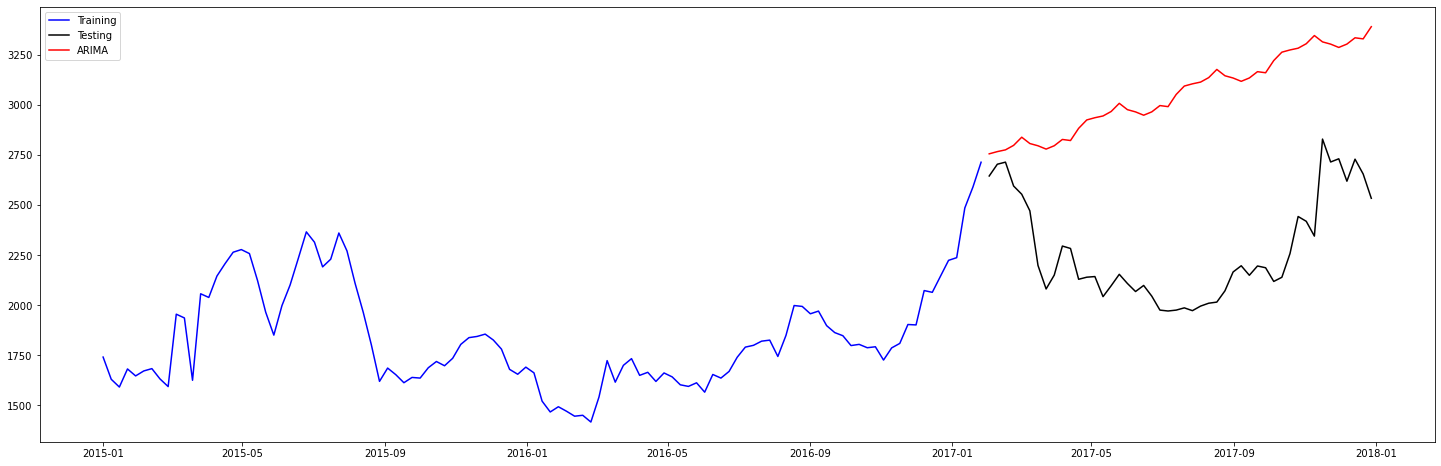

In [50]:
prediction = pd.DataFrame(model.predict(n_periods = len(test)), index = test.index)
prediction.columns = ['predicted_values']
#prediction

print("RMSE:", np.sqrt(mean_squared_error(test, prediction)))
plt.figure(1)
plt.rcParams['figure.figsize'] = (25,8)
plt.plot(train, 'b', label='Training')
plt.plot(test, 'k', label = 'Testing')
plt.plot(prediction, 'r', label = 'ARIMA')
plt.legend()
plt.show()

In [43]:
train_stat, stat_test = MakeStationaryLPC(train, plotting=False)
train_stat = pd.DataFrame(train_stat)
train_stat


Beginning stationary correction via differencing
There are 1 non-stationary features
Diff	p-value
1 	 1.363206065052949e-18 	 Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America
...running iteration: 1 complete
 0 values remain to be corrected


,"Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America_Delta1"
date,
2015-01-01,-0.065841
2015-01-08,-0.065841
2015-01-15,-0.024086
2015-01-22,0.055244
2015-01-29,-0.020907
...,...
2016-12-29,0.036549
2017-01-05,0.005988
2017-01-12,0.105253


In [44]:
model = auto_arima(train_stat, 
    start_p=0, d=1, start_q=0, 
    max_p=4, max_d=4, max_q=4, 
    start_P=0, D=1, start_Q=0, 
    max_P=4, max_D=4, max_Q=4, 
    seasonal=True, m=12, error_action='warn', trace = True, suppress_warnings=False, stepwise=True, random_state=2, n_fits = 10)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-163.451, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-198.369, Time=0.45 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-185.026, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-203.710, Time=0.68 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-202.123, Time=1.13 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-206.704, Time=1.43 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-208.402, Time=0.73 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-210.394, Time=0.35 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-186.521, Time=0.23 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=i

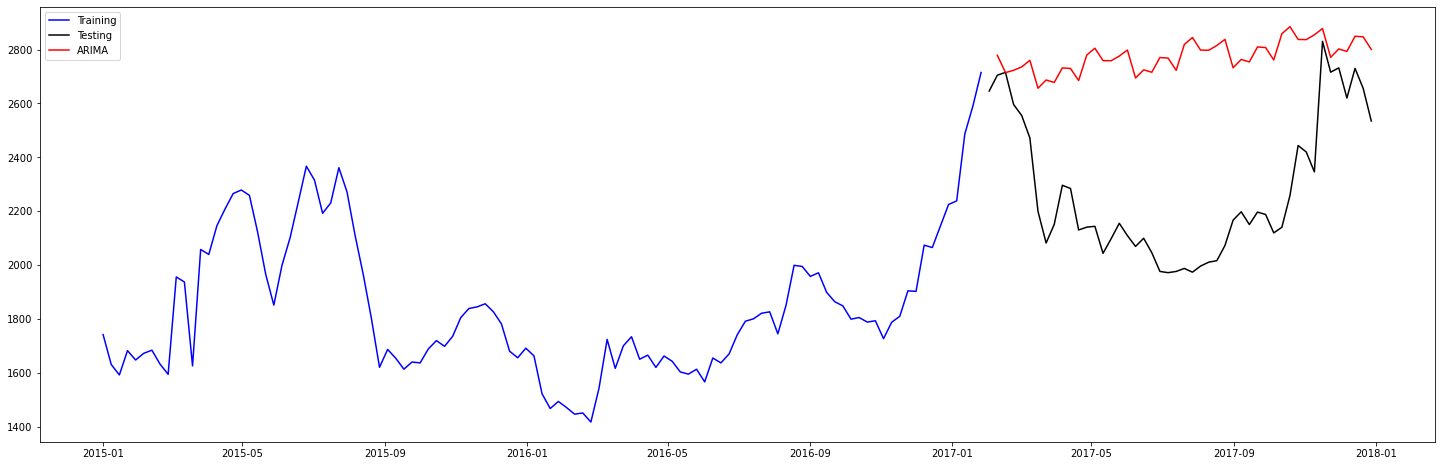

In [45]:
prediction_stat = pd.DataFrame(model.predict(n_periods = len(test)), index = test.index)
prediction = unLPC(train, prediction_stat)
prediction.columns = ['predicted_values']
#prediction

print('RMSE:', np.sqrt(mean_squared_error(test[1:].dropna(), prediction.dropna())))
plt.figure(1)
plt.rcParams['figure.figsize'] = (25,8)
plt.plot(train, 'b', label='Training')
plt.plot(test, 'k', label = 'Testing')
plt.plot(prediction, 'r', label = 'ARIMA')
plt.legend()
plt.show()